# CS 175 Project - SoundsLikeTrump

## Install External Libraries from PyPi

In [1]:
!pip install tweet-preprocessor
!pip install Rouge
!pip install torch
!pip install unidecode
!pip install textgenrnn

## Import Libraries and Load Dataset

In [4]:
# Basic Libraries
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import preprocessor.api as p #tweet pre-processor
from unidecode import unidecode #decode unicode to ascii
import html
import nltk
import re
nltk.download('punkt')

# ML Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import keras

# Evaluation Methods
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
from nltk.translate.nist_score import sentence_nist
nltk.download('stopwords')

# Other
from collections import Counter
from copy import deepcopy
import math
import time
import warnings
warnings.filterwarnings('ignore')
import urllib.request, json

# Dataset
# dataset_url = 'https://raw.githubusercontent.com/kevinnguyen125/CS175/master/realdonaldtrump.json'
dataset_url = 'https://raw.githubusercontent.com/kevinnguyen125/CS175/master/realdonaldtrump_updated.json' # Most up-to-date to 03/15/20
with urllib.request.urlopen(dataset_url) as url:
    dataset = json.loads(url.read().decode('utf-8'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Initial Pre-processing

In [0]:
tweets = [tweet['text'] for tweet in dataset]

# Set options to unnecessary attributes in tweets  
p.set_options('urls','mentions','reserved_words','emojis','smileys')
tweets = [p.clean(t) for t in tweets]

# Remove non-ASCII characters
tweets = [unidecode(t) for t in tweets]

# Unescape HTML entities
tweets = [html.unescape(t) for t in tweets]

# Ignore sentences that have anything in: '"()[]{}
reject = re.compile(r"'|\"|“|”|\(|\)|\[|\]|{|}")
tweets = [t for t in tweets if not reject.search(t)]

# Tokenize tweets
tokenized_tweets = [t.split() for t in tweets] # change later to account for word.word2

# Remove single character punctuation like '.' and ','
for i in range(len(tokenized_tweets)):
    for t in tokenized_tweets[i]:
        if len(t) == 1 and t in ':.,!':
            tokenized_tweets[i].remove(t)

# Get Random Original Tweets from the Dataset (that were pre-processed)
# preprocessed_tweets = np.array([' '.join(tokens) for tokens in tokenized_tweets])
# from random import randint

# for i in range(20):
#     index = randint(0,len(preprocessed_tweets)-1)
#     tweet = preprocessed_tweets[index]
#     if len(tweet) >= 50 and len(tweet) <= 280:
#         print(tweet)

## Markov Chain Model

In [0]:
# Reference: https://towardsdatascience.com/simulating-text-with-markov-chains-in-python-1a27e6d13fc6
# We followed the above tutorial but made many changes to fit our needs.
# We also referenced the Markovify library for a few things about sentence generation

class Markov_Chain:
    def __init__(self, tokenized_tweets, ngram_count=2, overlap_ratio=0.7):
        self.markov_chain = {}
        self.ngram_count = ngram_count
        self.overlap_ratio = overlap_ratio

        self.rejoined_text = '\n'.join([' '.join(tokens) for tokens in tokenized_tweets])

        ngrams = []
        for tokens in tokenized_tweets:
            ngrams.extend(list(nltk.ngrams(tokens,self.ngram_count)))

        for ngram in ngrams: # Form ngrams to subsequent words probability distribution
            key = ' '.join(ngram[:self.ngram_count-1])
            if key not in self.markov_chain:
                self.markov_chain[key] = []
            self.markov_chain[key].append(ngram[-1])

    def is_valid_sentence(self, chain, max_length, min_length): # Check that a sentence if within a max and min length
        sentence = ' '.join(chain)

        if len(sentence) > max_length or len(sentence) < min_length:
            return False 

        overlap = int(round(self.overlap_ratio * len(chain)))
        gram_count = max((len(chain) - overlap), 1)
        grams = [chain[i:i+overlap+1] for i in range(gram_count)]
        for g in grams:
            joined = ' '.join(g)
            if joined in self.rejoined_text:
                return False

        return True

    def make_sentence(self, tries=20, max_length=280, min_length=50, starting=None): # Generate a sentence
        ending = re.compile(r"\.|\!|\?|\*$")

        for i in range(tries):
            if not starting:
                first_ngram = np.random.choice(list(self.markov_chain.keys()))

                # allow exceptions for abbrievations e.g. U.S. or U.S.A.
                while not first_ngram[0].isalnum() or first_ngram[0].islower() or ending.search(first_ngram) or "#" in first_ngram:
                    first_ngram = np.random.choice(list(self.markov_chain.keys()))
                chain = first_ngram.split()
            else:
                chain = starting.split()
                if len(chain) != self.ngram_count-1:
                    raise Exception('Starting phrase ngram count is incorrect')

            try:
                prev_ngram = ' '.join(chain[-(self.ngram_count-1):])

                while not ending.search(prev_ngram) and prev_ngram in self.markov_chain:
                    chain.append(np.random.choice(self.markov_chain[prev_ngram]))
                    prev_ngram = ' '.join(chain[-(self.ngram_count-1):])
            except Exception as e:
                print('\nENCOUNTERED ERROR:',e,'\n')
            finally:
                if self.is_valid_sentence(chain,max_length,min_length):
                    return ' '.join(chain)

    def top_starting(self, n=5): # Return top starting phrases for the (n-1)-gram 
        d = Counter({ k: len(v) for k,v in self.markov_chain.items() if k[0].isupper() } )

        result = {}
        for k,v in d.most_common(n):
            result[k] = v
        
        return result

### Markov Chain Tweets

In [0]:
# Initialize Markov Chain model with n-grams
mc = Markov_Chain(tokenized_tweets,ngram_count=3,overlap_ratio=0.6)

In [41]:
# Generate Tweets
sentences = []
for i in range(30):
    # s = mc.make_sentence(starting='I')
    s = mc.make_sentence()
    sentences.append(s)
    print(s)

# markov_bleu = 0
# smoothing = SmoothingFunction().method4
# for i,s in enumerate(sentences):
#     bleu_score = sentence_bleu(tokenized_tweets,s,smoothing_function=smoothing,weights=(0.1,0.35,0.35,0.2))
    # nist_score = sentence_nist(tokenized_tweets,s)
    # rouge_score = Rouge().get_scores(s,'\n'.join([' '.join(tokens) for tokens in tokenized_tweets]))
    # markov_bleu += bleu_score

    # print(s)
    # print('BLEU:',bleu_score)
    # print('NIST:',nist_score)
    # print('ROUGE:',rouge_score)
    # print()

#     print(i, end=' ')
#     if i%100 == 0:
#         print('\n')
# print(markov_bleu / 100)

Honored heroic wounded warriors today at my meeting with Prime Minister of Japan and looking forward to my meeting at 9:00 P.M.
Does not have our brave men & women who protect our Nation and I loved beating these two US R...
Unbelievable support in Florida law, gave the jury little other choice than to know about Crooked Dems is....
CHANGE, I WILL fix this rigged system and protect our Nation Safe, Strong and as many questions as possible when I mentioned my eerience with our Farmers!
Nevada: A quick reminder that today is just another Washington D.C.
Australia, New Zealand, regarding the incoming Speaker of the men who had no answers by our leaders are bound by the...
They love the spirit and passion than ever before!
CIA deserves our praise for taking the first ever #NBC #SweepsTweet.
FBI, Department of Justice, will become Reciprocal & a Governors runoff in Alabama.
WTO is unfair and should never have been serving as policemen in Afghanistan, and that cannot protect its borders is m

### Starting Phrase Visualizations

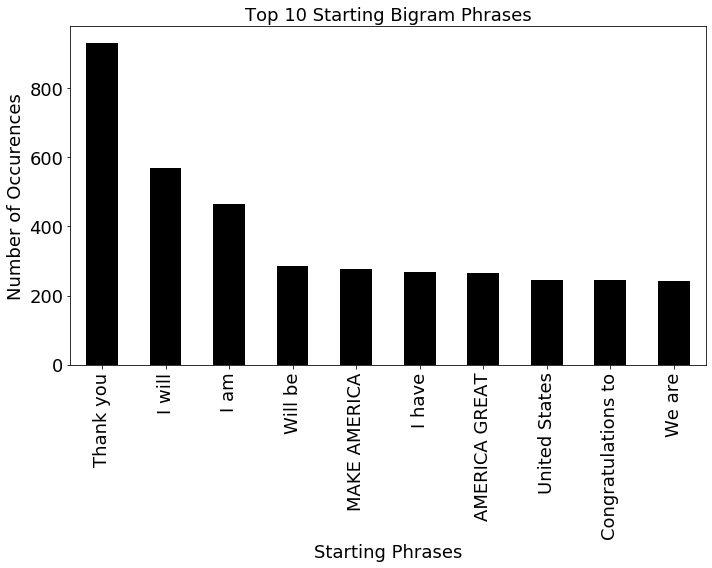

In [45]:
# Most Common Starting Words Plot
# Change ngram count in Markov Chain initialization in the previous 
# cells to genereate starting (n-1)-gram starting phrases
import matplotlib as mpl
COLOR='black'
# COLOR = '#05FECD'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rc('axes',edgecolor=COLOR)

start_freq = mc.top_starting(10)
starting_df = pd.DataFrame(list(start_freq.items()),columns=['Phrase','Count'])
fig = starting_df.plot.bar(figsize=(10,8), color=COLOR, fontsize=18)

plt.xticks(range(len(start_freq)),[x[0] for x in start_freq.items()])
plt.title('Top 10 Starting Bigram Phrases',fontsize=18)
plt.xlabel('Starting Phrases',fontsize=18)
plt.ylabel('Number of Occurences',fontsize=18)
plt.legend().remove()
plt.tight_layout()
plt.savefig('starting.png', transparent=True, edgecolor='r', linewidth=2)
plt.show()

## Neural Network Pre-processing (Word-Level)

In [0]:
# Loose guidance from https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
# but doing word-level RNN instead of character-level RNN and using different embedding and PyTorch training techniques

# Copy list of tokens
nn_tokenized_tweets = np.array(deepcopy(tokenized_tweets))
max_sentence_len = len(max(nn_tokenized_tweets, key=len))
nn_tokenized_tweets = np.array([t + [' ']*(max_sentence_len-len(t)) for t in nn_tokenized_tweets]) # Pad sentences to longest one

# Get set of all unique tokens
vocabulary = set(t for tokens in nn_tokenized_tweets for t in tokens)
vocabulary = np.array(list(vocabulary))

# Words -> Integer Encoding -> One Hot Encoding
label_encoder = LabelEncoder()
integer_encoding = label_encoder.fit_transform(vocabulary).reshape((-1,1)) # Vocabulary -> Integer encoding

onehot_encoder = OneHotEncoder(sparse=True)
onehot_encoding = onehot_encoder.fit_transform(integer_encoding) # Integer encoding -> One hot encoding

# Input sequences
input_word_seq = np.array([label_encoder.transform(t) for t in nn_tokenized_tweets[:,:-1]])
input_word_seq = np.array([onehot_encoder.transform(seq.reshape(-1,1)).tocoo() for seq in input_word_seq])
input_word_seq = torch.stack([torch.sparse.FloatTensor(torch.LongTensor(np.vstack((seq.row, seq.col))), torch.FloatTensor(seq.data), torch.Size(seq.shape)) for seq in input_word_seq])

# Target sequences
target_word_seq = np.array([label_encoder.transform(t) for t in nn_tokenized_tweets[:,1:]])
target_word_seq = torch.FloatTensor(target_word_seq)

# Constants
batch_size, seq_len, vocab_size = input_word_seq.shape

# Input encoding -> Words/Sentence
# x = np.argmax(csr_matrix(input_word_seq[0].to_dense().numpy()),axis=1)
# inverse = label_encoder.inverse_transform(x)
# ' '.join(inverse).strip()

## Simple RNN Model (Word-Level)

In [7]:
# Determine devices
device_to = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_from = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
print('From {} -> {}'.format(device_from,device_to))

class Simple_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(Simple_RNN, self).__init__()

        # Store parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) # RNN layer
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer
    
    def forward(self, x):
        # Initialize hidden layer
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x.to_dense(), hidden) # Pass through model and get output
        out = out.contiguous().view(-1, self.hidden_size) # Reshape output for fully connected layer
        out = self.fc(out) # Convert RNN output to our desired output

        return out, hidden
    
    def init_hidden(self, batch_size):
        # Generate first hidden state of zeros for forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size) #.to_sparse()
        hidden = hidden.to(device_to)
        return hidden


def train_RNN(rnn, input_seq, target_seq, batch_size=100, num_epochs=50, learning_rate=0.01):
    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

     # Shuffle input and target data in same manner
    random_indices = torch.randperm(len(input_seq)).tolist()
    shuffled_input = torch.utils.data.Subset(input_seq, random_indices)
    shuffled_target = torch.utils.data.Subset(target_seq, random_indices)

    # Load data in batches
    input_data = torch.utils.data.DataLoader(dataset=shuffled_input, batch_size=batch_size, shuffle=False, drop_last=True) # Try with drop_last=False later
    target_data = torch.utils.data.DataLoader(dataset=shuffled_target, batch_size=batch_size, shuffle=False, drop_last=True)
    total_tweets = len(input_data)*batch_size

    # Define Loss, Optimizer, Initial Hidden Layer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # Move RNN to device
    rnn.to(device_to)

    # Keep track of time
    start = time.time()

    # Keep track of loss
    loss_history = []

    # Training process
    for epoch in range(1, num_epochs+1):
        for i,(input_mini_batch,target_mini_batch) in enumerate(zip(input_data,target_data)):
            # Move tensors to device
            input_mini_batch = input_mini_batch.to(device_to)
            target_mini_batch = target_mini_batch.to(device_to)

            # Forward pass and compute the loss
            output, hidden = rnn(input_mini_batch)
            loss = criterion(output,target_mini_batch.view(-1).long())

            # Backpropogate and calcuate gradients to update weights/parameters
            optimizer.zero_grad() # Clear existing gradients
            loss.backward()
            optimizer.step()

            # Track loss
            if i == 0:
                loss_history.append(loss.item())

            # Clear Cache
            torch.cuda.empty_cache()

            if (i+1)%(2000//batch_size) == 0:
                print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                    .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))
        
        # Print at end of epoch if necessary
        if (i+1)%(2000//batch_size) != 0:
            print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))
    
    return loss_history

From cpu -> cuda


In [8]:
# Instantiate the Simple RNN model with hyperparameters
rnn = Simple_RNN(input_size=vocab_size, hidden_size=20, output_size=vocab_size, n_layers=1)

# Train Simple RNN!
loss_history = train_RNN(rnn, input_word_seq, target_word_seq, batch_size=250, num_epochs=50, learning_rate=0.01)

Epoch[1/50] | Tweets[2000/19250] | Loss: 8.9053 | Memory: 4.07GB | Time: 0m 8s
Epoch[1/50] | Tweets[4000/19250] | Loss: 6.1242 | Memory: 4.07GB | Time: 0m 17s
Epoch[1/50] | Tweets[6000/19250] | Loss: 3.8739 | Memory: 4.07GB | Time: 0m 25s
Epoch[1/50] | Tweets[8000/19250] | Loss: 2.5994 | Memory: 4.07GB | Time: 0m 34s
Epoch[1/50] | Tweets[10000/19250] | Loss: 3.1674 | Memory: 4.07GB | Time: 0m 42s
Epoch[1/50] | Tweets[12000/19250] | Loss: 2.8088 | Memory: 4.07GB | Time: 0m 51s
Epoch[1/50] | Tweets[14000/19250] | Loss: 2.7711 | Memory: 4.07GB | Time: 1m 0s
Epoch[1/50] | Tweets[16000/19250] | Loss: 2.6271 | Memory: 4.07GB | Time: 1m 8s
Epoch[1/50] | Tweets[18000/19250] | Loss: 2.8557 | Memory: 4.07GB | Time: 1m 17s
Epoch[1/50] | Tweets[19250/19250] | Loss: 2.6323 | Memory: 4.07GB | Time: 1m 22s
Epoch[2/50] | Tweets[2000/19250] | Loss: 2.7405 | Memory: 4.07GB | Time: 1m 31s
Epoch[2/50] | Tweets[4000/19250] | Loss: 2.7218 | Memory: 4.07GB | Time: 1m 40s
Epoch[2/50] | Tweets[6000/19250] | Lo

### Simple RNN Loss Visualization

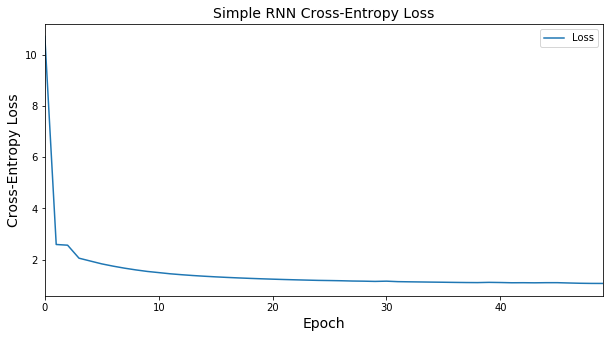

In [25]:
loss_df = pd.DataFrame(loss_history)
loss_df.columns = ['Loss']
loss_df.plot(figsize=(10,5))

plt.title('Simple RNN Cross-Entropy Loss', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.show()

## GRU Model (Word-Level)

In [26]:
# Determine devices
device_to = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_from = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
print('From {} -> {}'.format(device_from,device_to))

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()

        # Store paramaters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # self.encoder = nn.Embedding(input_size, hidden_size) # Test later
        self.gru = nn.GRU(input_size, hidden_size, n_layers,batch_first=True, bidirectional=False) # GRU Layer
        self.fc = nn.Linear(hidden_size, output_size) # Fully Connected Layer
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        # x = self.encoder(x.to_dense().view(1,-1).long()) # Test later
        out, hidden = self.gru(x.to_dense(), hidden) # Pass through model and get output
        out = out.contiguous().view(-1, self.hidden_size) # Reshape output for fully connected layer
        out = self.fc(out) # Convert GRU output to our desired output
        
        return out, hidden

    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        hidden = hidden.to(device_to)
        return hidden

def train_GRU(gru, input_seq, target_seq, batch_size=100, num_epochs=50, learning_rate=0.01):
    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

     # Shuffle input and target data in same manner
    random_indices = torch.randperm(len(input_seq)).tolist()
    shuffled_input = torch.utils.data.Subset(input_seq, random_indices)
    shuffled_target = torch.utils.data.Subset(target_seq, random_indices)

    # Load data in batches
    input_data = torch.utils.data.DataLoader(dataset=shuffled_input, batch_size=batch_size, shuffle=False, drop_last=True) # Try with drop_last=False later
    target_data = torch.utils.data.DataLoader(dataset=shuffled_target, batch_size=batch_size, shuffle=False, drop_last=True)
    total_tweets = len(input_data)*batch_size

    # Define Loss, Optimizer, Initial Hidden Layer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

    # Move GRU to device
    gru.to(device_to)

    # Keep track of time
    start = time.time()

    # Keep track of loss
    loss_history = []

    # Training process
    for epoch in range(1, num_epochs+1):
        for i,(input_mini_batch,target_mini_batch) in enumerate(zip(input_data,target_data)):
            # Move tensors to device
            input_mini_batch = input_mini_batch.to(device_to)
            target_mini_batch = target_mini_batch.to(device_to)

            # Forward pass and compute the loss
            output, hidden = gru(input_mini_batch)
            loss = criterion(output,target_mini_batch.view(-1).long())

            # Backpropogate and calcuate gradients to update weights/parameters
            optimizer.zero_grad() # Clear existing gradients
            loss.backward()
            optimizer.step()

            # Track loss
            if i == 0:
                loss_history.append(loss.item())

            # Clear Cache
            torch.cuda.empty_cache()

            if (i+1)%(2000//batch_size) == 0:
                print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                    .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))
        
        # Print at end of epoch if necessary
        if (i+1)%(2000//batch_size) != 0:
            print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))
    return loss_history

From cpu -> cuda


In [27]:
gru = GRU(input_size=vocab_size, hidden_size=100, output_size=vocab_size, n_layers=1)
loss_history = train_GRU(gru, input_word_seq, target_word_seq, batch_size=250, num_epochs=25, learning_rate=0.015)

Epoch[1/25] | Tweets[2000/19250] | Loss: 3.0438 | Memory: 4.07GB | Time: 0m 9s
Epoch[1/25] | Tweets[4000/19250] | Loss: 3.0169 | Memory: 4.07GB | Time: 0m 19s
Epoch[1/25] | Tweets[6000/19250] | Loss: 2.8334 | Memory: 4.07GB | Time: 0m 29s
Epoch[1/25] | Tweets[8000/19250] | Loss: 2.5968 | Memory: 4.07GB | Time: 0m 39s
Epoch[1/25] | Tweets[10000/19250] | Loss: 2.5020 | Memory: 4.07GB | Time: 0m 49s
Epoch[1/25] | Tweets[12000/19250] | Loss: 2.1444 | Memory: 4.07GB | Time: 0m 59s
Epoch[1/25] | Tweets[14000/19250] | Loss: 2.1608 | Memory: 4.07GB | Time: 1m 9s
Epoch[1/25] | Tweets[16000/19250] | Loss: 2.2196 | Memory: 4.07GB | Time: 1m 19s
Epoch[1/25] | Tweets[18000/19250] | Loss: 2.1583 | Memory: 4.07GB | Time: 1m 29s
Epoch[1/25] | Tweets[19250/19250] | Loss: 2.2053 | Memory: 4.07GB | Time: 1m 36s
Epoch[2/25] | Tweets[2000/19250] | Loss: 1.9586 | Memory: 4.07GB | Time: 1m 46s
Epoch[2/25] | Tweets[4000/19250] | Loss: 1.9394 | Memory: 4.07GB | Time: 1m 56s
Epoch[2/25] | Tweets[6000/19250] | L

### GRU Loss Visualization

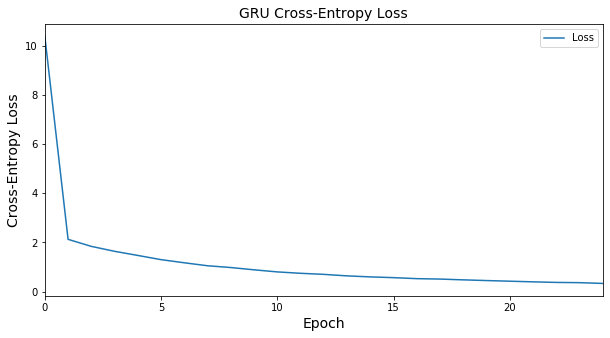

In [28]:
loss_df = pd.DataFrame(loss_history)
loss_df.columns = ['Loss']
loss_df.plot(figsize=(10,5))

plt.title('GRU Cross-Entropy Loss', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.show()

## LSTM Model (Word-Level)

In [29]:
# Determine devices
device_to = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_from = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
print('From {} -> {}'.format(device_from,device_to))

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()

        # Store paramaters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # self.encoder = nn.Embedding(input_size, hidden_size) # Test later
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True, bidirectional=False) # LSTM Layer
        self.fc = nn.Linear(hidden_size, output_size) # Fully Connected Layer
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        # x = self.encoder(x.to_dense().view(1,-1).long()) # Test later
        out, hidden = self.lstm(x.to_dense(), hidden) # Pass through model and get output
        out = out.contiguous().view(-1, self.hidden_size) # Reshape output for fully connected layer
        out = self.fc(out) # Convert LSTM output to our desired output
        
        return out, hidden

    def init_hidden(self, batch_size):
        h_0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)) # First hidden layer
        h_0 = h_0.to(device_to)

        c_0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)) # Second hidden layer
        c_0 = c_0.to(device_to)

        return (h_0,c_0)

def train_LSTM(lstm, input_seq, target_seq, batch_size=100, num_epochs=50, learning_rate=0.01):
    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

     # Shuffle input and target data in same manner
    random_indices = torch.randperm(len(input_seq)).tolist()
    shuffled_input = torch.utils.data.Subset(input_seq, random_indices)
    shuffled_target = torch.utils.data.Subset(target_seq, random_indices)

    # Load data in batches
    input_data = torch.utils.data.DataLoader(dataset=shuffled_input, batch_size=batch_size, shuffle=False, drop_last=True) # Try with drop_last=False later
    target_data = torch.utils.data.DataLoader(dataset=shuffled_target, batch_size=batch_size, shuffle=False, drop_last=True)
    total_tweets = len(input_data)*batch_size

    # Define Loss, Optimizer, Initial Hidden Layer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Move LSTM to device
    lstm.to(device_to)

    # Keep track of time
    start = time.time()

    # Keep track of loss
    loss_history = []

    # Training process
    for epoch in range(1, num_epochs+1):
        for i,(input_mini_batch,target_mini_batch) in enumerate(zip(input_data,target_data)):
            # Move tensors to device
            input_mini_batch = input_mini_batch.to(device_to)
            target_mini_batch = target_mini_batch.to(device_to)

            # Forward pass and compute the loss
            output, hidden = lstm(input_mini_batch)
            loss = criterion(output,target_mini_batch.view(-1).long())
            
            # Backpropogate and calcuate gradients to update weights/parameters
            optimizer.zero_grad() # Clear existing gradients
            loss.backward()
            optimizer.step()

            # Track loss
            if i == 0:
                loss_history.append(loss.item())

            # Clear Cache
            torch.cuda.empty_cache()

            if (i+1)%(2000//batch_size) == 0:
                print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                    .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))
        
        # Print at end of epoch if necessary
        if (i+1)%(2000//batch_size) != 0:
            print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))
    
    return loss_history

From cpu -> cuda


In [30]:
lstm = LSTM(input_size=vocab_size, hidden_size=100, output_size=vocab_size, n_layers=1)
loss_history = train_LSTM(lstm, input_word_seq, target_word_seq, batch_size=250, num_epochs=25, learning_rate=0.015)

Epoch[1/25] | Tweets[2000/19250] | Loss: 2.8874 | Memory: 4.07GB | Time: 0m 10s
Epoch[1/25] | Tweets[4000/19250] | Loss: 3.3261 | Memory: 4.07GB | Time: 0m 21s
Epoch[1/25] | Tweets[6000/19250] | Loss: 3.2171 | Memory: 4.07GB | Time: 0m 31s
Epoch[1/25] | Tweets[8000/19250] | Loss: 2.9796 | Memory: 4.07GB | Time: 0m 42s
Epoch[1/25] | Tweets[10000/19250] | Loss: 2.9104 | Memory: 4.07GB | Time: 0m 52s
Epoch[1/25] | Tweets[12000/19250] | Loss: 2.6984 | Memory: 4.07GB | Time: 1m 3s
Epoch[1/25] | Tweets[14000/19250] | Loss: 2.6913 | Memory: 4.07GB | Time: 1m 13s
Epoch[1/25] | Tweets[16000/19250] | Loss: 2.5069 | Memory: 4.07GB | Time: 1m 24s
Epoch[1/25] | Tweets[18000/19250] | Loss: 2.6334 | Memory: 4.07GB | Time: 1m 34s
Epoch[1/25] | Tweets[19250/19250] | Loss: 2.4422 | Memory: 4.07GB | Time: 1m 41s
Epoch[2/25] | Tweets[2000/19250] | Loss: 2.2575 | Memory: 4.07GB | Time: 1m 51s
Epoch[2/25] | Tweets[4000/19250] | Loss: 2.3361 | Memory: 4.07GB | Time: 2m 2s
Epoch[2/25] | Tweets[6000/19250] | L

### LSTM Loss Visualization

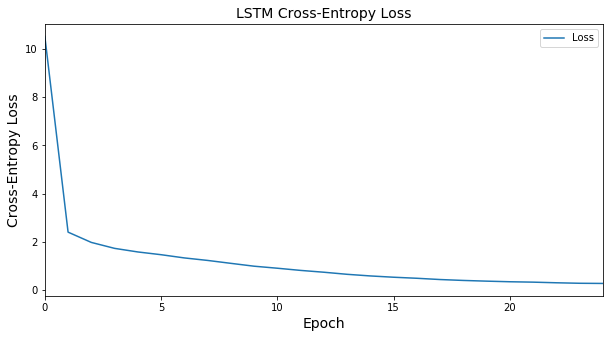

In [31]:
loss_df = pd.DataFrame(loss_history)
loss_df.columns = ['Loss']
loss_df.plot(figsize=(10,5))

plt.title('LSTM Cross-Entropy Loss', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.show()

## RNN/GRU/LSTM Tweet Generation

### Word-Level Tweet Generation Code

In [0]:
def convert_to_words(encoder, sequence):
    # Bring tensors in GPU back to CPU
    if sequence.is_cuda:
        sequence = sequence.cpu()

    # Convert from tensor -> numpy -> reverse integer encoding -> words
    if len(sequence.shape) == 2:
        integer_encoding = np.argmax(csr_matrix(sequence.to_dense().numpy()),axis=1)
    else:
        integer_encoding = sequence.numpy().reshape(-1,1).astype(np.int64)
    inverse = encoder.inverse_transform(integer_encoding)
    sentence = ' '.join(inverse).strip()

    return sentence

def is_valid_sentence(chain, max_length, min_length, overlap_ratio=0.6):
    sentence = ' '.join(chain)
    if len(sentence) > max_length or len(sentence) < min_length:
        return False
    
    rejoined_text = '\n'.join([' '.join(tokens) for tokens in tokenized_tweets])
    overlap = int(round(overlap_ratio * len(chain)))
    gram_count = max((len(chain) - overlap), 1)
    grams = [chain[i:i+overlap+1] for i in range(gram_count)]
    for g in grams:
        joined = ' '.join(g)
        if joined in rejoined_text:
            # print('OVERLAPPED!!!')
            return False
    return True

def predict(model, words, k):
    # Convert input -> integer encoding -> one-hot encoding -> tensor to fit into the model
    words_seq = label_encoder.transform(words)
    words_seq = onehot_encoder.transform(words_seq.reshape(-1,1)).tocoo()
    words_seq = torch.stack([torch.sparse.FloatTensor(torch.LongTensor(np.vstack((words_seq.row, words_seq.col))), torch.FloatTensor(words_seq.data), torch.Size(words_seq.shape))])
    words_seq = words_seq.to(device_to)

    # Send input into model
    out, hidden = model(words_seq)

    # Take random word with top k highest probability
    prob = nn.functional.softmax(out[-1], dim=0).data
    top_k = torch.argsort(prob)[-k:]
    word_integer_encoding = np.array([top_k[torch.randperm(top_k.size(0))[0]].item()])
    word = label_encoder.inverse_transform(word_integer_encoding)[0]

    return word, hidden

def make_sentence(model, max_length=280, min_length=50, tries=20, start='I', k=5):
    # Put model (RNN/GRU/LSTM) in eval mode
    model.eval()

    # Ending characters
    ending = re.compile(r"\.|\!|\?|\*$")

    for i in range(tries):
        # Set up starting phrase
        words = start.split()

        prev_word = words[-1]
        while not ending.search(prev_word):
            predicted_word, h = predict(model, words, k)

            if predicted_word != ' ': # Ignore padding (find a better way to handle this later)
                words.append(predicted_word)
                prev_word = predicted_word
        
        if is_valid_sentence(words,max_length,min_length):
            return ' '.join(words)

### RNN Tweets

In [51]:
rnn_generated_tweets = []
for i in range(20):
    tweet = make_sentence(rnn,start='I',k=3) # Must provide starting phrase
    rnn_generated_tweets.append(tweet)
    print(tweet)

# rnn_bleu = 0
# smoothing = SmoothingFunction().method4 # Smoothing is necessary due to relatively small size of the generated tweet compared to the corpus
# for i,s in enumerate(rnn_generated_tweets):
#     bleu_score = sentence_bleu(tokenized_tweets,s,smoothing_function=smoothing,weights=(0.1,0.35,0.35,0.2))
#     rnn_bleu += bleu_score

#     print(s)
#     print('BLEU score:',bleu_score)
#     print()

#     print(i, end=' ')
#     if i%100 == 0:
#         print('\n')
# print(rnn_bleu / 100) # Print Average BLEU Score

I will never be in the Republican Party, which we will be great.
I have been a big job for being done in a total joke!
I will not be allowed to be doing well to see the great honor to welcome the election.
I have not gotten to be in Singapore with a new poll of U.S.
I will never have gone back and very well in Washington.
I will never be in your and total Endorsement for Iowa on November 8th, and low I.Q.
I am not being given big trade deals with President Obama is getting worse.
I have not been done by the great State is being made.
I have been really well as well in North Carolina.
I am pleased of a great guy who has served the U.S.
I have a major level staffer that is a total winner!
I am going to be with my speech on the great State is a great honor and have to be with a fantastic job!
I am pleased of losers who will never have not allow more time in order and Vets.
I will not have been needed to Ohio tomorrow and very special LP.
I am pleased to imagine what the Nielsen Webber Ter

### GRU Tweets

In [53]:
gru_generated_tweets = []
for i in range(20):
    tweet = make_sentence(gru,start='Obama',k=3) # Must provide starting phrase
    gru_generated_tweets.append(tweet)
    print(tweet)

# gru_bleu = 0
# smoothing = SmoothingFunction().method4 # Smoothing is necessary due to relatively small size of the generated tweet compared to the corpus
# for i,s in enumerate(gru_generated_tweets):
#     bleu_score = sentence_bleu(tokenized_tweets,s,smoothing_function=smoothing,weights=(0.1,0.35,0.35,0.2))
#     gru_bleu += bleu_score

#     print(s)
#     print('BLEU score:',bleu_score)
#     print()

#     print(i, end=' ')
#     if i%100 == 0:
#         print('\n')
# print(gru_bleu / 100) # Print Average BLEU Score

Obama Care is now worse and more than ever to the places in the middle class.
Obama Care is still not risk over a lose politician when the action when there is not to be back in the country.
Obama has my office yesterday- with two great job of office!
Obama Care are still with your economy, intelligence able that too earlier conference my change.
Obama has blocked over our country, military with my office numerous money.
Obama is now warning John McCain too high Iran deals maker.
Obama has zero respect for WWII vets to our enemy the dollar he will allow waterboarding he has no amnesty, he would be used to defend his trial.
Obama Care will eventually approve the Keystone Pipeline.
Obama has zero energy on fraud from the same time.
Obama is finally block from oil for using the most dangerous dollar about play it to be paid to ISIS than Obama fully immediately impact on our economy.
Obama is finally fighting through Americans especially by days.
Obama is now warning John Sanders are only 

### LSTM Tweets

In [99]:
# BLEU score for LSTM tweets
lstm_generated_tweets = []
for i in range(20):
    tweet = make_sentence(lstm,start='The United States',k=3) # Must provide starting phrase
    lstm_generated_tweets.append(tweet)
    print(tweet)

# lstm_bleu = 0
# smoothing = SmoothingFunction().method4 # Smoothing is necessary due to relatively small size of the generated tweet compared to the corpus
# for i,s in enumerate(lstm_generated_tweets):
#     bleu_score = sentence_bleu(tokenized_tweets,s,smoothing_function=smoothing,weights=(0.1,0.35,0.35,0.2))
#     lstm_bleu += bleu_score

#     print(s)
#     print('BLEU score:',bleu_score)
#     print()

#     print(i, end=' ')
#     if i%100 == 0:
#         print('\n')
# print(lstm_bleu / 100) # Print Average BLEU Score

The United States needs an extra $4B while China loves our Country as President that will be immediately fixed.
The United States needs to be doctors not allow Amazon all Senate!
The United States needs an absolute worst Border Security have cost crime than any other day.
The United States has been informed to announce that it will keep this a.m.,
The United States needs a GREAT day allowing a single year ago, government attack in Turkey, history.
The United States will impose long heavy coverage so on far better than ever anticipated, absolutely no Turkish Dollars on He will be a tremendous addition and many great things they have done nothing about me.
The United States needs a fortune on special interest played into one about me after she did.
The United States needs an extra donation to is necessary reason wants things done to do that wants to change this costly work throughout our economy!
The United States has foolishly given money for the money the Summit and if death penalty.
T

### Neural Network Pre-processing (Character-Level)

In [0]:
# Re-clean tweets BUT leave in characters in '"()[]{} this time
tweets = [tweet['text'] for tweet in dataset]
p.set_options('urls','mentions','reserved_words','emojis','smileys')
tweets = [p.clean(t) for t in tweets]
tweets = [unidecode(t) for t in tweets]
tweets = [html.unescape(t) for t in tweets]

# TESTING STOPWORD REMOVAL
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens_list =[t.split() for t in tweets]
for i,tokens in enumerate(tokens_list):
    tokens = [t for t in tokens if t not in stop_words]
    tokens_list[i] = tokens
tweets = [' '.join(t) for t in tokens_list]

# Make a list of list of characters and remove empty/one-character tweets (that resulted from pre-processing).
nn_char_tweets = [list(t)+['<EOS>'] for t in tweets if len(list(t)) > 1]
max_sentence_len = len(max(nn_char_tweets, key=len))
nn_char_tweets = np.array([t + ['<PAD>']*(max_sentence_len-len(t)) for t in nn_char_tweets]) # Pad sentences to longest one

# Get set of all unique characters
vocabulary = set(t for tokens in nn_char_tweets for t in tokens)
vocabulary = np.array(list(vocabulary))

# Characters -> Integer Encoding -> One Hot Encoding
label_encoder = LabelEncoder()
integer_encoding = label_encoder.fit_transform(vocabulary).reshape((-1,1)) # Vocabulary -> Integer encoding

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoding = onehot_encoder.fit_transform(integer_encoding) # Integer encoding -> One hot encoding

# Input sequences
input_char_seq = np.array([label_encoder.transform(t) for t in nn_char_tweets[:,:-1]])
input_char_seq = np.array([onehot_encoder.transform(seq.reshape(-1,1)) for seq in input_char_seq])
input_char_seq = torch.FloatTensor(input_char_seq)

# Target sequences
target_char_seq = np.array([label_encoder.transform(t) for t in nn_char_tweets[:,1:]])
target_char_seq = torch.FloatTensor(target_char_seq)

# Constants
batch_size, seq_len, vocab_size = input_char_seq.shape

# Input encoding -> Chars -> Sentence
# x = np.argmax(input_char_seq[0],axis=1)
# inverse = filter(lambda x: x != '<PAD>', label_encoder.inverse_transform(x))
# ''.join(inverse).strip()

### Simple RNN (Character-Level)
Our attempt to doing character-level RNN. We needed to do more research to get better, readable results, but we didn't have enough time remaining.

In [7]:
# Determine devices
device_to = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_from = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
print('From {} -> {}'.format(device_from,device_to))

class Simple_Char_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, embedding_size=50):
        super(Simple_Char_RNN, self).__init__()

        # Store parameters
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # Layers
        # self.embed = nn.Embedding(input_size, embedding_size) # PyTorch Embedding Layer
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) # RNN layer
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer
    
    def forward(self, x):
        # Initialize hidden layer
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        # x = self.embed(x.to(torch.int64))
        out, hidden = self.rnn(x, hidden) # Pass through model and get output
        out = out.contiguous().view(-1, self.hidden_size) # Reshape output for fully connected layer
        out = self.fc(out) # Convert RNN output to our desired output

        return out, hidden
    
    def init_hidden(self, batch_size):
        # Generate first hidden state of zeros for forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size) #.to_sparse()
        hidden = hidden.to(device_to)
        return hidden


def train_Char_RNN(rnn, input_seq, target_seq, batch_size=10000, num_epochs=50, learning_rate=0.01):
    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

     # Shuffle input and target data in same manner
    random_indices = torch.randperm(len(input_seq)).tolist()
    shuffled_input = torch.utils.data.Subset(input_seq, random_indices)
    shuffled_target = torch.utils.data.Subset(target_seq, random_indices)

    # Load data in batches
    input_data = torch.utils.data.DataLoader(dataset=shuffled_input, batch_size=batch_size, shuffle=False, drop_last=True) # Try with drop_last=False later
    target_data = torch.utils.data.DataLoader(dataset=shuffled_target, batch_size=batch_size, shuffle=False, drop_last=True)
    total_tweets = len(input_data)*batch_size

    # Define Loss, Optimizer, Initial Hidden Layer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    # Move RNN to device
    rnn.to(device_to)

    # Keep track of time
    start = time.time()

    # Training process
    for epoch in range(1, num_epochs+1):
        for i,(input_mini_batch,target_mini_batch) in enumerate(zip(input_data,target_data)):
            # Move tensors to device
            input_mini_batch = input_mini_batch.to(device_to)
            target_mini_batch = target_mini_batch.to(device_to)

            # Forward pass and compute the loss
            output, hidden = rnn(input_mini_batch)
            loss = criterion(output,target_mini_batch.view(-1).long())

            # Backpropogate and calcuate gradients to update weights/parameters
            optimizer.zero_grad() # Clear existing gradients
            loss.backward()
            optimizer.step()

            # Clear Cache
            torch.cuda.empty_cache()

            print('Epoch[{}/{}] | Tweets[{}/{}] | Loss: {:.4f} | Memory: {:.2f}GB | Time: {}'
                .format(epoch, num_epochs, (i+1)*batch_size, total_tweets, loss.item(), torch.cuda.memory_reserved()/1e+9, timeSince(start)))

From cpu -> cuda


In [8]:
# Instantiate the Simple RNN model with hyperparameters
char_rnn = Simple_Char_RNN(input_size=vocab_size, hidden_size=200, output_size=vocab_size, n_layers=1)

# Train Simple RNN!
train_Char_RNN(char_rnn, input_char_seq, target_char_seq, batch_size=2500, num_epochs=25, learning_rate=0.01)

Epoch[1/25] | Tweets[2500/30000] | Loss: 4.5349 | Memory: 0.65GB | Time: 0m 0s
Epoch[1/25] | Tweets[5000/30000] | Loss: 3.9436 | Memory: 0.65GB | Time: 0m 1s
Epoch[1/25] | Tweets[7500/30000] | Loss: 1.5593 | Memory: 0.65GB | Time: 0m 1s
Epoch[1/25] | Tweets[10000/30000] | Loss: 1.3970 | Memory: 0.65GB | Time: 0m 2s
Epoch[1/25] | Tweets[12500/30000] | Loss: 1.5323 | Memory: 0.65GB | Time: 0m 3s
Epoch[1/25] | Tweets[15000/30000] | Loss: 1.5594 | Memory: 0.65GB | Time: 0m 3s
Epoch[1/25] | Tweets[17500/30000] | Loss: 1.6517 | Memory: 0.65GB | Time: 0m 4s
Epoch[1/25] | Tweets[20000/30000] | Loss: 1.4957 | Memory: 0.65GB | Time: 0m 4s
Epoch[1/25] | Tweets[22500/30000] | Loss: 1.3420 | Memory: 0.65GB | Time: 0m 5s
Epoch[1/25] | Tweets[25000/30000] | Loss: 1.3689 | Memory: 0.65GB | Time: 0m 6s
Epoch[1/25] | Tweets[27500/30000] | Loss: 1.3567 | Memory: 0.65GB | Time: 0m 6s
Epoch[1/25] | Tweets[30000/30000] | Loss: 1.2694 | Memory: 0.65GB | Time: 0m 7s
Epoch[2/25] | Tweets[2500/30000] | Loss: 1.

### Char-Level Tweet Generation Code

In [0]:
def is_valid_sentence(chain, max_length, min_length, overlap_ratio=0.6): # Check if tweet is valid
    sentence = ''.join(chain)
    if len(sentence) > max_length or len(sentence) < min_length:
        return False
    
    rejoined_text = '\n'.join(tweets)
    overlap = int(round(overlap_ratio * len(chain)))
    gram_count = max((len(chain) - overlap), 1)
    grams = [chain[i:i+overlap+1] for i in range(gram_count)]
    for g in grams:
        joined = ' '.join(g)
        if joined in rejoined_text:
            print('OVERLAPPED!!!')
            return False
    return True

def predict(model, chars, k):
    # Convert input -> integer encoding -> one-hot encoding -> tensor to fit into the model
    char_seq = label_encoder.transform(chars)
    char_seq = onehot_encoder.transform(char_seq.reshape(-1,1))
    char_seq = torch.stack([torch.FloatTensor(char_seq)])
    char_seq = char_seq.to(device_to)

    # Send input into model
    out, hidden = model(char_seq)

    # Take random char with top k highest probability
    prob = nn.functional.softmax(out[-1], dim=0).data
    top_k = torch.argsort(prob)[-k:]
    char_integer_encoding = np.array([top_k[torch.randperm(top_k.size(0))[0]].item()])
    char = label_encoder.inverse_transform(char_integer_encoding)[0]

    return char, hidden

def make_sentence(model, max_length=280, min_length=50, tries=20, start='I', k=5):
    # Put char-level model (RNN/GRU/LSTM) in eval mode
    model.eval()

    for i in range(tries):
        # Set up starting phrase
        chars = list(start)

        prev_char = chars[-1]
        while prev_char != '<EOS>' and len(chars) < 280: # Keep adding characters until <EOS> is reached
            predicted_char, h = predict(model, chars, k)

            if predicted_char != '<PAD>': # Ignore padding
                chars.append(predicted_char)
                prev_char = predicted_char
        
        if is_valid_sentence(chars,max_length,min_length):
            return ''.join(chars).strip()

In [15]:
char_rnn_generated_tweets = []
for i in range(20):
    tweet = make_sentence(char_rnn,start='I',k=3)
    print(tweet)
    char_rnn_generated_tweets.append(tweet)

I'tren arioller alintiows,0 preatesticende tonden canession warsess.. We tous tort stes ales conder stest cath seserere tiondend coned sicoun torica tiots.. Tontint.. Thent. I tortint terint ceales. I thars. Tong toul stion.<EOS>
I T INT IN Ther Senesticess sinen wanten wous seating tontersinestiont cathe test statiots coun stater ceatiol toredines anicentica caticten sestiond. Ithantion tored.<EOS>
Inendersion are ticatere sean starsess cersiontictentiot roull canter starsice praterer cant sticte peates anisest ces ales coriticande siolers cound.<EOS>
I he stiont ste tonding caling testersicantingr arsionte seateres,0 thanten coun wath tines. Trice statesteres ses cate porices.. Int romen corsered. Whicen thartess.<EOS>
I'  lerint reriness call cant ales seantiots.<EOS>
I henesintererent seat aricorent sioler corst arinen ceale teand siows,, ceriows cant ate ticentioller sinest catiolentiot. Whicticatines catiol sich wars sesest caled cond mealle stant randiot stes aringent stat singe

Again, these results are gibberish and nonsense, so we still need to do much more research regarding character-level neural networks.